# **Classification male/female on Reddit messages dataset**

In [ ]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the training data

The first line of the csv is automatically set as column names

In [ ]:
train_data = pd.read_csv("./train_data.csv", encoding="utf8")
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [4]:
train_data.loc[train_data.author=='morbiusgreen']
print(train_data.groupby('author').subreddit.value_counts(normalize= False).idxmax())
print(train_data.loc[train_data.author=='morbiusgreen'].subreddit.value_counts())

('morbiusgreen', 'ExploreFiction')
ExploreFiction       15045
RatedRFiction         4438
shortscarystories       20
IAmAFiction              6
FictionBrawl             6
AskReddit                4
spaceporn                3
doctorwho                3
gaming                   1
AskMen                   1
FanTheories              1
DaystromInstitute        1
WritingPrompts           1
photoshopbattles         1
MST3K                    1
anime                    1
StarWars                 1
Name: subreddit, dtype: int64


In [5]:
train_target = pd.read_csv("./train_target.csv")
train_target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


In [6]:
nmex=shape((train_data.author))

from collections import Counter
ngender=Counter(train_target.gender)

print('we have %d subreddits' %train_data.subreddit.nunique())
print('we have %d reddit messages' %nmex[0])
print('from %d authors' %train_data.author.nunique())
print('of which %d male and %d female' %(ngender[0],ngender[1]))
print(train_target.gender.value_counts(normalize= True))

we have 3468 subreddits
we have 296042 reddit messages
from 5000 authors
of which 3651 male and 1349 female
0    0.7302
1    0.2698
Name: gender, dtype: float64


In [7]:
train_matrix = pd.merge(train_target,train_data).sort_values('author')

text_gender=Counter(train_matrix.gender)
print('%d messages from male and %d from female' %(text_gender[0],text_gender[1]))
train_matrix.head()

228657 messages from male and 67385 from female


,author,gender,subreddit,created_utc,body
128584,-Jared,0,AskReddit,1.391118e+09,"No, I think YOU mean Taylor Ham... Really, wha..."
128583,-Jared,0,AskReddit,1.391113e+09,And nothing beats a hangover quite like bacon ...
128582,-Jared,0,StarWars,1.390497e+09,If you had a bad motivator would you want to s...
128581,-Jared,0,pics,1.390493e+09,Looks like the pattern on the envelope that mi...
128580,-Jared,0,tall,1.390190e+09,+1 on the chiropractor. I went religiously fro...


we can already see 2 major problems in our dataset:
* The dataset is unbalanced, we have more than double number of male authors than female authors, and it's even worse with the single messages
* We have too many features than vectors, so we can expect some overfitting

we will address them later if necessary

# Data Processing and Feature Extraction
Let's just stop for a minute to analyze what are our hypotesis:
* We could use subreddits as features, because we think that the choice of the subreddit could be influenced by gender
* We could use the texts as features because we could search for patterns in the use of specific terms between men and women.
* We could weight the subreddits according to the number of times a user has wrote on it 
* We could use the authors as feature vectors or the single messages

So we think that probably men/women use most often certains words in their phrases or prefer a certain type of subjects.


In this section we want to create the matrices we will use to train our model.

### SUBREDDITS FEATURE EXTRACTION

We start by associating each unique subreddit with an index number

In [8]:
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))
#shape[0] gives us only the number of subreddits, otherwise we have a tuple
#and data gives an index number to each unique subreddit
print(subreddits_map)

mylittlepony            0
sex                     1
DragonsDogma            2
malefashionadvice       3
todayilearned           4
                     ... 
palegirls            3463
onions               3464
mumfordandsons       3465
infertility          3466
HangoutFest          3467
Length: 3468, dtype: int64


Now let's define the function extract_features, that will create a vector of all the subreddit of a selected group (in our case of the different authors)

In [9]:
from scipy import sparse

def extract_features(group):
    group_subreddits = group['subreddit']

    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    
    idxs = subreddits_map.loc[group_subreddits].values
    #vector of the indexes of the subreddits of the specified author
    v = sparse.dok_matrix((1, subreddits.shape[0])) 
    #create a sparse matrix that count which subreddits appear in the specified group
    for idx in idxs:
        if not np.isnan(idx):
           #v[0, idx] += 1
            v[0, idx] = 1
    return v.tocsr()

#example
extract_features(train_data[train_data.author=='ProjectGrudge'])
#train_data[train_data.author=='RedThunder90'] select all the rows from author RedThunder90
#basically we search for the indexes referring to author RedThunder90
print(extract_features(train_data[train_data.author=='ProjectGrudge']))
shape(extract_features(train_data[train_data.author=='ProjectGrudge']))

  (0, 120)	1.0
  (0, 1646)	1.0
  (0, 7)	1.0
  (0, 95)	1.0
  (0, 17)	1.0
  (0, 1850)	1.0
  (0, 971)	1.0


(1, 3468)

Now we create the feature dictionary using the function we just created: we have each author connected to its sparse matrix of the subreddits

In [10]:
features_dict = {}

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

print(features_dict['RedThunder90'])

  (0, 103)	1.0


Now we make sure that each author is in our target and it's in the right order, and we create the feature matrix of the subreddits

In [11]:
X_sub = sparse.vstack([features_dict[author] for author in train_target.author])
print('X_sub has %d authors' %X_sub.shape[0])
print('X_sub has %d subreddits' %X_sub.shape[1])
#create a sparse matrix of the authors that are in the target with associated sub vectors

X_sub has 5000 authors
X_sub has 3468 subreddits


### TARGET MATRIX

Now let's the create the matrix of the target values

In [12]:
y_target = train_target.gender
#is the column of the gender without the authors
y_target

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    1
4997    0
4998    1
4999    0
Name: gender, Length: 5000, dtype: int64

### TEXT FEATURE EXTRACTION

Now let's try to do the same thing we did with the subreddits but with the text of the messages.
First we need a function that joins all the text from the same author.

In [13]:
#this function joins all the text from a person togheter separating with a space
def extract_text(group):
    group_text = group['body'].values
    return " ".join(map(str, group_text))
    #return " ".join(group_text)


#example
extract_text(train_data[train_data.author=='ProjectGrudge']);

Then we do the same as before, creating a dictionary with authors and related text

In [14]:
text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)
#the groups we iterate are the different authors dataframes related to the author names
#so we are creating a dictionary with keys authors and datas the text of the messages

#example
text_dict['RedThunder90']


'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

and as before we create a vector with the texts that verify the order and the target authors

In [15]:
author_text = [text_dict[author] for author in train_target.author]
author_text[1][:200]
#author_text is a matrix with indexes of the authors and their messages splitted by characters

"A+ name, friend. Ten points to Gryffindor. [Hyperbole and a Half](http://hyperboleandahalf.blogspot.com/2013/05/depression-part-two.html) has the best explanation I've ever seen. My friends who strugg"

we still have to make a matrix of all the words as features, similarly as we did with the subreddits, because now we have just a bunch of letters, we do not have the numerical vectors as in the subreddits.
Moreover we want to limit stopwords,numbers and short words.

To do this we use CountVectorizer that is a super useful method of scikitlearn, made for text feature extraction.
We also use TfidTrasnformer to weight the words that are present too many times in our dataset.

(The parameters of the vectorizer have been found using some crossvalidation in another notebook, not here in order to mantain this one more tidy and fast)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS, TfidfVectorizer

pattern ='(?u)\\b[A-Za-z]{3,}'
#pattern indica il tipo di parole che cerchiamo, in questo caso parole che iniziano con lettere dalla a alla z
# e da minimo 3 lettere

stop_words = set(list(ENGLISH_STOP_WORDS))

#cv = CountVectorizer(token_pattern=pattern, stop_words=stop_words, ngram_range=(1, 2), max_df=0.9)
cv = CountVectorizer(token_pattern=pattern, stop_words=stop_words,max_df=100, min_df=7)
#cv = CountVectorizer(token_pattern=pattern, stop_words=stop_words,max_features=20000)
#countvectorizer è una funzione con molti parametri che serve a creare la feature matrix dei messaggi
#ngram indica gli ngrammi(?), ossia prossiamo prendere come features anche gruppi di più di una lettera.
C = cv.fit_transform(author_text)

tfidf = TfidfTransformer()
                        
#calculate features using tf-idf and create a training set 
X_text = tfidf.fit_transform(C)
print()
print("X_train is a sparse matrix with shape: %s" % str(X_text.shape))
#matrice sparsa tiene in memoria solo elementi diversi da zero, utile per ottimizzare
print()


X_train is a sparse matrix with shape: (5000, 21494)



# Model Selection

Now let's try different models with different data (subreddit/text)

We will start with the Multinomial NaiveBayes method, that is used quite a lot in text analysis.

We will start with the **subreddits**

In [17]:
# create a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def model_test(model,X,y) :
    model.fit(X, y)

    print('Accuracy in')
    print(model.score(X,y))
    print('Accuracy out')
    print(cross_val_score(model, X, y, cv=10).mean())
    print('roc auc score:')
    print(roc_auc_score(y, model.predict_proba(X)[:,1]))
    print('roc auc out')
    print(cross_val_score(model, X, y, cv=10, scoring= 'roc_auc').mean())
    return()
    

In [18]:
model = MultinomialNB()
model_test(model,X_sub,y_target)

Accuracy in
0.894
Accuracy out
0.8644000000000001
roc auc score:
0.9423043617120852
roc auc out
0.9046221671913408


()

Lets' try to optimize the crossvalidation score with some regularization

In [19]:
def alpha_selection(model,X,y):
    
    alphas = np.logspace(-2, 0, 50)
    scores = []

    for alpha in alphas:
        model.alpha = alpha
        s = cross_val_score(model, X,y, cv=10,scoring= 'roc_auc')
        scores.append(s.mean())

    plot(alphas, scores)
    plt.xscale('log')
    max_score= max(scores)
    #print(max_score)
    #print(scores.index(max_score))
    
    best_alpha = alphas[np.argmax(scores)]
    best_model= MultinomialNB(alpha=best_alpha, class_prior=[0.7,0.3])
    best_model.fit(X, y)
    print('best_alpha %f'%best_alpha)
    print('Accuracy in')
    print(best_model.score(X,y))
    print('Accuracy out')
    print(cross_val_score(best_model, X, y, cv=10).mean())
    print('roc auc score:')
    print(roc_auc_score(y, best_model.predict_proba(X)[:,1]))
    print('roc auc out')
    roc_auc_out= cross_val_score(best_model, X, y, cv=10, scoring= 'roc_auc').mean()
    print(roc_auc_out)
    
    return(best_alpha,roc_auc_out)

best_alpha 0.429193
Accuracy in
0.8994
Accuracy out
0.8603999999999999
roc auc score:
0.9508390422397147
roc auc out
0.9080257660719532


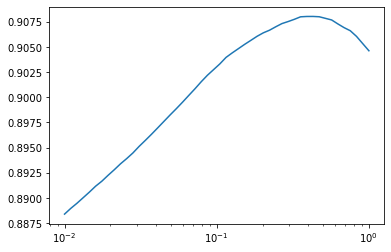

In [20]:
best_alpha_sub,weight_sub_model= alpha_selection(model,X_sub,y_target)

**Repeat same process but with the matrix of all texts**

In [21]:
model = MultinomialNB()
model_test(model,X_text,y_target)

Accuracy in
0.8492
Accuracy out
0.7864000000000001
roc auc score:
0.9691706873163907
roc auc out
0.8395133641372198


()

best_alpha 0.071969
Accuracy in
0.9512
Accuracy out
0.8283999999999999
roc auc score:
0.981570389338583
roc auc out
0.8531275905821593


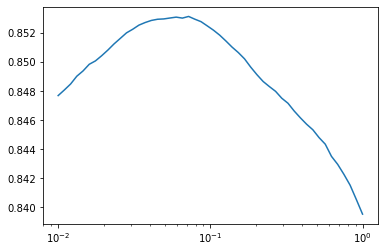

In [22]:
best_alpha_text,weight_text_model= alpha_selection(model, X_text,y_target)

As we expected with a lot of features regularization plays a strong part

**we can try with with the union of both sub and text matrices**

In [23]:
from scipy.sparse import hstack
X_tot= sparse.hstack((X_sub,X_text))

In [24]:
model = MultinomialNB()

model_test(model,X_tot,y_target)

Accuracy in
0.9036
Accuracy out
0.8592000000000001
roc auc score:
0.952852869498268
roc auc out
0.894799085144182


()

best_alpha 0.167683
Accuracy in
0.9416
Accuracy out
0.8642
roc auc score:
0.9766035849515929
roc auc out
0.9131547985302424


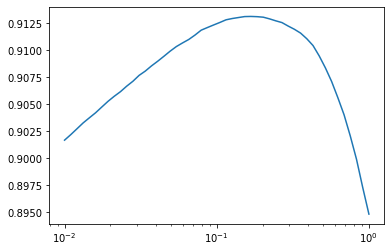

In [25]:
best_alpha_tot,weight_tot_model= alpha_selection(model,X_tot, y_target)

We can see that the increase in the parameters resulted in a slightly better result

Now there are some other things we can try
* We can try to combine the weighted results of every model
    * Ensemble model (best result)
* We can try with some truncated SVD to reduce the number of features
    * Tried but does not work well
* we can obviously try with other methods
    * Almost every other method I tried did worse than the Naive Bayes

**Mixing test sets and models**

<br>
we weight the different models using their roc_auc out

In [26]:
model_sub = MultinomialNB(alpha= best_alpha_sub)
model_text = MultinomialNB(alpha= best_alpha_text)
model_tot = MultinomialNB(alpha= best_alpha_tot)

model_sub.fit(X_sub,y_target)
model_text.fit(X_text, y_target)
model_tot.fit(X_tot,y_target)


y_pred_sub= model_sub.predict_proba(X_sub)[:,1]
y_pred_text= model_text.predict_proba(X_text)[:,1]
y_pred_tot= model_tot.predict_proba(X_tot)[:,1]

y_pred = (y_pred_text * weight_text_model + y_pred_sub * weight_sub_model + y_pred_tot * weight_tot_model)/(weight_text_model+ weight_sub_model+ weight_tot_model)

from sklearn.metrics import roc_auc_score

print("roc auc in for ensemble model %f " %roc_auc_score(y_target, y_pred))

roc auc in for ensemble model 0.981042 


In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier


#bunch of things i tried

#model= SGDClassifier(loss="log", penalty="l2", max_iter=10000)
#model= SGDClassifier(loss="log", penalty="elasticnet")
#model= BaggingClassifier(base_estimator=MultinomialNB(),n_estimators=10, random_state=0,max_samples=0.9, verbose=1)
#estimator= SGDClassifier(loss="log", max_iter=10000)
#estimator= DecisionTreeClassifier(max_depth=3,random_state=0)
#model= AdaBoostClassifier(n_estimators=100, random_state=0)
#model= AdaBoostClassifier( base_estimator=estimator ,n_estimators=10, random_state=0)
#model= AdaBoostRegressor(base_estimator=SGDClassifier(loss="log", penalty="l2", max_iter=1000) n_estimators=50, random_state=0)
#model= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)

model= SGDClassifier(loss="log", penalty="elasticnet")

model_test(model,X_tot,y_target)

Accuracy in
0.9524
Accuracy out
0.849
roc auc score:
0.9954857661588902
roc auc out
0.8913860408266328


()

let's try to find out the best regularization

In [41]:
def alpha_selection_SGDC(model,X,y):
    
    alphas = np.logspace(-4, -3, 10)
    scores = []

    for alpha in alphas:
        model.alpha = alpha
        s = cross_val_score(model, X,y, cv=10,scoring= 'roc_auc')
        scores.append(s.mean())

    plot(alphas, scores)
    plt.xscale('log')
    max_score= max(scores)
    print(max_score)
    #print(scores.index(max_score))
    
    best_alpha = alphas[np.argmax(scores)]
    #best_alpha = alphas[scores.index(max_score)]

    best_model= SGDClassifier(loss="log", penalty="elasticnet", alpha=best_alpha)
    #model.alpha= best_alpha
    best_model= model
    best_model.fit(X, y)
    print('best_alpha %f'%best_alpha)
    print('Accuracy in')
    print(best_model.score(X,y))
    print('Accuracy out')
    print(cross_val_score(best_model, X, y, cv=10).mean())
    print('roc auc score:')
    print(roc_auc_score(y, best_model.predict_proba(X)[:,1]))
    print('roc auc out')
    roc_auc_out= cross_val_score(best_model, X, y, cv=10, scoring= 'roc_auc').mean()
    print(roc_auc_out)
        
    return(best_alpha,roc_auc_out)

0.8942284521450438
best_alpha 0.000167
Accuracy in
0.8598
Accuracy out
0.8432000000000001
roc auc score:
0.919978664821462
roc auc out
0.885309871594196


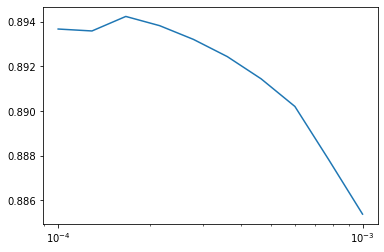

In [42]:
model= SGDClassifier(loss="log", penalty="elasticnet")
best_alpha_tot_SGDC,weight_tot_model_SGDC= alpha_selection_SGDC(model,X_tot, y_target)

because of the stochastic nature of the method is possible to find a worst Eout. Probably looking at the graph the default 0.0001 will be a good choice

let's do the same for the ratio

In [43]:
def ratio_selection_SGDC(model,X,y):
    
    ratios = np.linspace(0, 0.1, 50)
    scores = []

    for ratio in ratios:
        model.l1_ratio = ratio
        s = cross_val_score(model, X,y, cv=10,scoring= 'roc_auc')
        scores.append(s.mean())

    plot(ratios, scores)
    plt.xscale('log')
    max_score= max(scores)
    print(max_score)
    #print(scores.index(max_score))
    
    best_ratio = ratios[np.argmax(scores)]
    #best_alpha = alphas[scores.index(max_score)]
    best_model= SGDClassifier(loss="log", penalty="elasticnet", alpha=best_alpha_tot_SGDC,l1_ratio=best_ratio)
    best_model.fit(X, y)
    print('best_ratio %f'%best_ratio)
    print('Accuracy in')
    print(best_model.score(X,y))
    print('Accuracy out')
    print(cross_val_score(best_model, X, y, cv=10).mean())
    print('roc auc score:')
    print(roc_auc_score(y, best_model.predict_proba(X)[:,1]))
    print('roc auc out')
    roc_auc_out= cross_val_score(best_model, X, y, cv=10, scoring= 'roc_auc').mean()
    print(roc_auc_out)
        
    return(best_ratio,roc_auc_out)

0.8978629325116316
best_ratio 0.014286
Accuracy in
0.9488
Accuracy out
0.8535999999999999
roc auc score:
0.9927080103768396
roc auc out
0.896622821963243


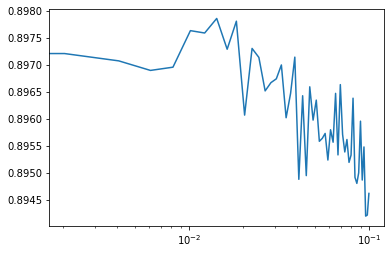

In [44]:
model= SGDClassifier(loss="log", penalty="elasticnet",alpha=best_alpha_tot_SGDC)
best_ratio_tot_SGDC,weight_tot_model_SGDC= ratio_selection_SGDC(model,X_tot, y_target)

also here, the best ratio is probably near the default 0.15

In [50]:
model.alpha=0.0001
model.l1_ratio= best_alpha_tot_SGDC
model_test(model,X_tot,y_target)

Accuracy in
0.9736
Accuracy out
0.852
roc auc score:
0.9973759435913149
roc auc out
0.8963314021007074


()

# Prepare the solution

Load test_data

In [53]:
test_data = pd.read_csv("./test_data.csv", encoding="utf8")
test_data.head(5)

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


Extraction for **subreddits**

In [54]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [55]:
X_test_sub = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
shape(X_test_sub)

(15000, 3468)

In [56]:
print(features_dict['ZenDragon'])
print('X_sub has %d authors' %X_test_sub.shape[0])
print('X_sub has %d subreddits' %X_test_sub.shape[1])
#create a sparse matrix of the authors that are in the target with associated sub vectors

  (0, 95)	1.0
  (0, 22)	1.0
  (0, 1072)	1.0
  (0, 19)	1.0
  (0, 775)	1.0
  (0, 45)	1.0
  (0, 1538)	1.0
  (0, 183)	1.0
  (0, 375)	1.0
  (0, 600)	1.0
  (0, 458)	1.0
  (0, 4)	1.0
  (0, 103)	1.0
  (0, 126)	1.0
  (0, 1092)	1.0
  (0, 251)	1.0
  (0, 41)	1.0
  (0, 120)	1.0
  (0, 212)	1.0
  (0, 278)	1.0
  (0, 283)	1.0
  (0, 3327)	1.0
  (0, 732)	1.0
  (0, 109)	1.0
  (0, 361)	1.0
  (0, 622)	1.0
  (0, 2007)	1.0
  (0, 7)	1.0
X_sub has 15000 authors
X_sub has 3468 subreddits


Extraction  for **texts**

In [57]:
text_dict_test = {}

for author, group in test_data.groupby('author'):
    text_dict_test[author] = extract_text(group)
    
text_dict_test['savoytruffle'];

In [58]:
author_text_test = [text_dict_test[author] for author in test_data.author.unique()]
author_text_test[1][:200]

'At 7680 by 4320 with 64x AA, right? Wrong subreddit for this kind of post, but /r/frugal and /r/lifeprotips might be interested. This is something GravityBox can do. (a module for XPosed Framework) Wh'

In [59]:
# extract features from raw text documents
#cv.fit(author_text)
C_test_text = cv.transform(author_text_test)
X_test_text = tfidf.transform(C_test_text)

Matrix of **sub+texts**

In [60]:
X_test_tot= sparse.hstack((X_test_sub,X_test_text))

**Ensemble model with also the logistic regression**

In [61]:
model_tot_SGDC= SGDClassifier(loss="log", penalty="elasticnet", alpha= best_alpha_tot_SGDC, l1_ratio=best_ratio_tot_SGDC)
#model_tot_SGDC= SGDClassifier(loss="log", penalty="elasticnet", alpha= 0.0001, l1_ratio=0.15)
model_tot_SGDC.fit(X_tot,y_target)

y_pred_sub= model_sub.predict_proba(X_test_sub)[:,1]
y_pred_text= model_text.predict_proba(X_test_text)[:,1]
y_pred_tot= model_tot.predict_proba(X_test_tot)[:,1]
y_pred_tot_SGDC= model_tot_SGDC.predict_proba(X_test_tot)[:,1]

y_pred = (y_pred_text * weight_text_model + y_pred_sub * weight_sub_model + y_pred_tot * weight_tot_model+y_pred_tot_SGDC*weight_tot_model_SGDC)/(weight_text_model+ weight_sub_model+ weight_tot_model+weight_tot_model_SGDC)

this has good results because different methods compensate each other

In [62]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

,author,gender
0,ejchristian86,0.993620
1,ZenDragon,0.000968
2,savoytruffle,0.004387
3,hentercenter,0.021517
4,rick-o-suave,0.096372


In [63]:
solution.to_csv("solution.csv", index=False)